# Model Fitting

Here we'll be working to come up with a model that describes a set of data. To hopefully explain the process better, let's make our own set of data.

In [26]:
using Plots, Optim, Distributions, StatsPlots

In [43]:
f(x,A,w) = A .* sin.(w .* x)
x = collect(0:0.1:10);

In [56]:
A = 1.0
w = 1.0
error = 0.1
noise = rand(Normal(0.0,0.1), length(x))
y = f(x,A,w) + noise;

Here is simply a sine function (with amplitude A, and angular frequency w) plus some guassian noise (with standard deviation of 0.1). 

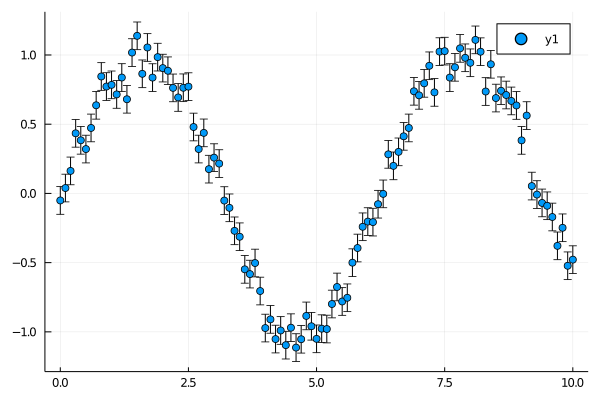

In [57]:
scatter(x, y, yerr=[error])

Now, let's say we did just make this data in the cells above, and that it comes from some measurements we made (perhaps transit times). We want to come up with a model that describes our data. Well, the data appear to be following a sine function, and we know how to express that:

$$f(x) = A*\sin(wx + p)$$

where $A$ is the amplitude, $w$ is the angular frequency, and $p$ is a shift in phase. Let's write it in Julia code:

In [58]:
function model_sin(x, A, w, p)
    return A * sin(w * x + p)
end

model_sin (generic function with 1 method)

Now to start, we can make a guess as to what the parameters of our model should be. A crude estimate can be done by eye.

In [59]:
Ag = 1.1         # Amplitude guess
P = 6.0          # Period guess
wg = 2.0 * π / P # Angular frequency guess
pg = 0.0         # Phase shift guess
yg = model_sin.(x, Ag, wg, pg);

Let's plot the model on top of the data.

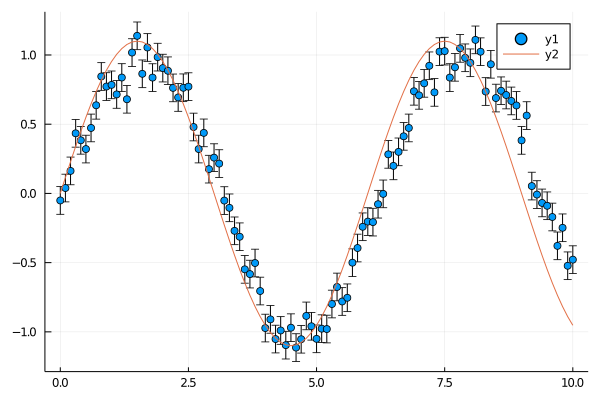

In [60]:
scatter(x,y,yerr=[error])
plot!(x,yg)

Not bad! But we can do better. Let's use a chi-squared to be more quantitative about our fit. It can be expressed as 

$$\chi^2 = \sum_{n}\left(\frac{x_n - \mu_{n,\theta}}{\sigma_n}\right)^2$$

where $x_n$ is the n-th data point, $\mu_n$ is the model evaluated at $x_n$ with a particular set of parameters $\theta$, and $\sigma_n$ is the error in $x_n$.

In [61]:
function chi2(model, data, error)
    return sum(((data .- model) ./ error).^2)
end

chi2 (generic function with 2 methods)

In [62]:
data = copy(y)
modelg = copy(yg);
error = [0.1];
chi2(data, modelg, error)

579.8479772310852

What is this actually saying? If we examine the $\chi^2$ function we can notice that the closer the model is to the data (in value), the smaller $\chi^2$ becomes. The other extreme is also worth noting: if the errors are very large $\chi^2$ would also be very small. But since we are so uncertain of our measurement, this doesn't mean our model fits well.

Now let's say that for each n, the term in the parethesis is equal to 1. This would mean that the difference between the data and the model is equal to the error! (Or, another way to phrase it, the model is describing the signal and leaving behind the noise). This would set our $\chi^2$ equal to 1 for each iteration of the sum, and so $\chi^2$ would be equal to the number of data points. This is where the reduced $\chi^2$ comes in -- typically expressed as $\chi^2 / dof$, where $dof$ denotes the "degrees of freedom". For our purposed the degrees of freedom are equal to the number of data point minus the number of parameters minus 1. From our observation above, it follows that a good fit would present a reduced $\chi^2$ as close to 1 as possible. That way we've minimized the distance between our model and data points while simulateously taking into account the error.

In [63]:
println("Reduced Chi-squared: ", chi2(data,modelg,error) / (length(data) - 3 - 1))

Reduced Chi-squared: 5.977814198258611


It looks like we have some room for improvement. Now we'll discuss how to find the best fit model parameters. Given we want chi-squared to be zero, let's simply minimize chi-squared. We'll be using the optimization package `Optim.jl`. (Recall that a large value of $\sigma$ would also give a small chi-squared. Here, we set that value, so this won't be a problem.)

In [64]:
# Rewrite chi-squared for Optim
# params = [A, w, p]
function chi2(params, x, y_data, y_error)
    y_model = model_sin.(x, params...)
    return sum(((y_data .- y_model) ./ y_error).^2)
end

chi2 (generic function with 2 methods)

In [65]:
# Again, guess at proper parameters
Ag = 1.1         # Amplitude guess
P = 6.0          # Period guess
wg = 2.0 * π / P # Angular frequency guess
pg = 0.0         # Phase shift guess
params = [Ag, wg, pg]

3-element Array{Float64,1}:
 1.1
 1.0471975511965976
 0.0

This is one way to use the optimizer within `Optim`. We need a function to minimize, an initial guess as to what our parameters should be, and the optimization method. This expression for chi-squared is such that only `p` is varied by the optimizer. We know what the data points and errors are, so they will stay fixed. Also, there are a number of optimizers, but `NelderMead` will do fine for now. (We'll look at others later.)

In [66]:
res = optimize(p -> chi2(p, x, y, error), params, NelderMead())

 * Status: success

 * Candidate solution
    Final objective value:     1.001532e+02

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    98
    f(x) calls:    193


In [67]:
println("Reduced chi-squared: ", res.minimum / (length(x) - 3 - 1))

Reduced chi-squared: 1.032506981500585


Much better!

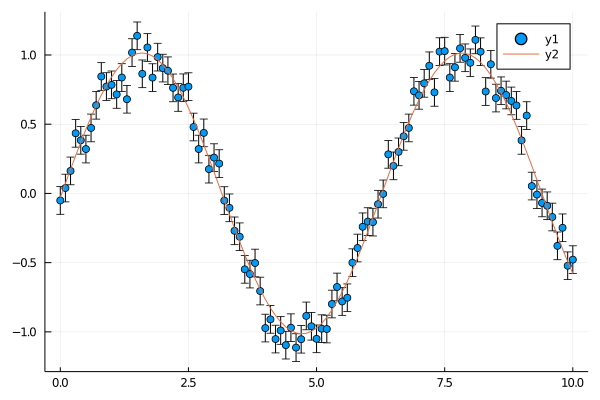

In [78]:
scatter(x,y,yerr=error)
plot!(x, model_sin.(x, res.minimizer...))

# Bonus: Residuals

We can also gain insight into how well our model performs by looking at the residuals (data - model).

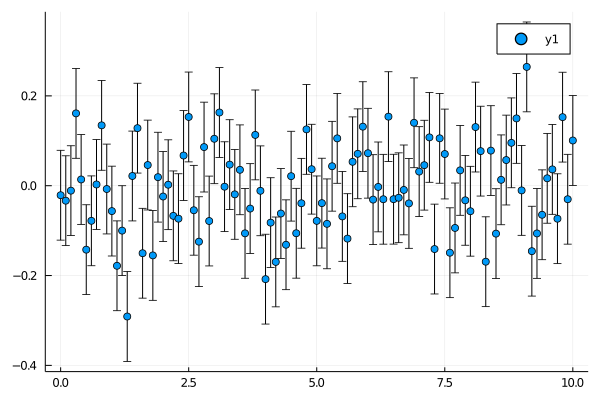

In [77]:
residuals = y .- model_sin.(x, res.minimizer...)
scatter(x, residuals, yerr=error)

One might say these appear to be random (and they should -- our noise is gaussian and the reduced chi-squared is of order 1). Let's plot a histogram, and see if we can fit a gaussian.

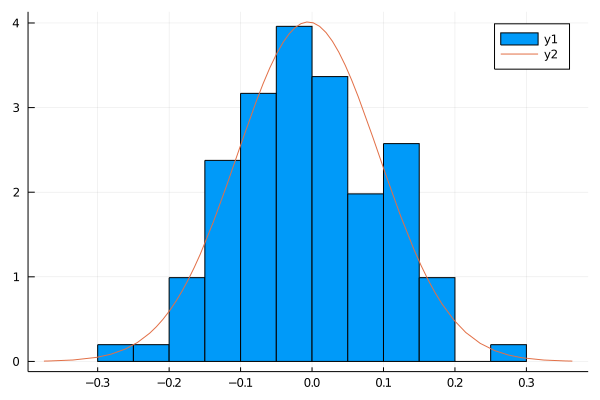

In [84]:
noise_model = fit_mle(Normal, residuals) # Find best fit from residuals
histogram(residuals, normalize=true, bins=15)
plot!(noise_model)

This fit seems reasonable -- we do have a small data set.